In [19]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [21]:
DATA_PATH = "/content/diabetes.csv"
TARGET_COL = "Outcome"


In [22]:
def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

In [23]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nHead:")
display(df.head())

Shape: (768, 9)

Columns: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']

Head:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [24]:
print("\nDescribe (numeric):")
display(df.describe())


Describe (numeric):


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [25]:
print("\nClass balance:")
print(df[TARGET_COL].value_counts())


Class balance:
Outcome
0    500
1    268
Name: count, dtype: int64


 Train/Test Split + Standardization (manual)

In [26]:

X = df.drop(columns=[TARGET_COL]).values.astype(np.float32)
y = df[TARGET_COL].values.astype(np.float32).reshape(-1, 1)

m = X.shape[0]
idx = np.random.permutation(m)
split = int(0.8 * m)
train_idx, test_idx = idx[:split], idx[split:]

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# Standardize with train stats
mu = X_train.mean(axis=0, keepdims=True)
sigma = X_train.std(axis=0, keepdims=True) + 1e-8
X_train = (X_train - mu) / sigma
X_test  = (X_test  - mu) / sigma

# To tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)

X_train_t.shape, y_train_t.shape, X_test_t.shape, y_test_t.shape


(torch.Size([614, 8]),
 torch.Size([614, 1]),
 torch.Size([154, 8]),
 torch.Size([154, 1]))

In [27]:
n_features = X_train_t.shape[1]

# Initialize parameters manually
W = torch.randn((n_features, 1), dtype=torch.float32, requires_grad=True)
b = torch.zeros(1, dtype=torch.float32, requires_grad=True)

# Hyperparams
lr = 1e-2
epochs = 1000
loss_history = []

for epoch in range(1, epochs + 1):
    # Linear -> Sigmoid
    z = X_train_t @ W + b        # (N,1)
    y_hat = sigmoid(z)           # probabilities in (0,1)

    # Binary Cross Entropy (manual)
    eps = 1e-8
    loss = -(y_train_t*torch.log(y_hat+eps) + (1 - y_train_t)*torch.log(1 - y_hat + eps)).mean()

    # Backprop (autograd)
    loss.backward()

    # Manual gradient descent step
    with torch.no_grad():
        W -= lr * W.grad
        b -= lr * b.grad

    # Zero grads
    W.grad.zero_()
    b.grad.zero_()

    loss_history.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}/{epochs} - loss: {loss.item():.4f}")

loss_history[-1]


Epoch 100/1000 - loss: 0.8710
Epoch 200/1000 - loss: 0.7777
Epoch 300/1000 - loss: 0.7088
Epoch 400/1000 - loss: 0.6563
Epoch 500/1000 - loss: 0.6155
Epoch 600/1000 - loss: 0.5835
Epoch 700/1000 - loss: 0.5582
Epoch 800/1000 - loss: 0.5382
Epoch 900/1000 - loss: 0.5226
Epoch 1000/1000 - loss: 0.5104


0.5103527903556824

In [28]:
@torch.no_grad()
def predict_proba(Xt):
    return sigmoid(Xt @ W + b)

@torch.no_grad()
def predict_label(Xt, threshold=0.5):
    probs = predict_proba(Xt)
    return (probs >= threshold).float(), probs

def accuracy(y_true, y_pred):
    return (y_true == y_pred).float().mean().item()

def confusion_counts(y_true, y_pred):
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)
    TP = ((y_true == 1) & (y_pred == 1)).sum().item()
    TN = ((y_true == 0) & (y_pred == 0)).sum().item()
    FP = ((y_true == 0) & (y_pred == 1)).sum().item()
    FN = ((y_true == 1) & (y_pred == 0)).sum().item()
    return TP, FP, TN, FN

def precision_recall_f1(TP, FP, TN, FN, eps=1e-12):
    precision = TP / (TP + FP + eps)
    recall    = TP / (TP + FN + eps)
    f1        = 2 * precision * recall / (precision + recall + eps)
    return precision, recall, f1

# Train metrics
preds_tr, probs_tr = predict_label(X_train_t, threshold=0.5)
acc_train = accuracy(y_train_t, preds_tr)

# Test metrics
preds_te, probs_te = predict_label(X_test_t, threshold=0.5)
acc_test = accuracy(y_test_t, preds_te)

TP, FP, TN, FN = confusion_counts(y_test_t, preds_te)
prec, rec, f1 = precision_recall_f1(TP, FP, TN, FN)

print(f"Train Accuracy: {acc_train:.4f}")
print(f"Test  Accuracy: {acc_test:.4f}")
print(f"Confusion Matrix (Test): TP={TP}  FP={FP}  TN={TN}  FN={FN}")
print(f"Precision={prec:.4f}  Recall={rec:.4f}  F1={f1:.4f}")


Train Accuracy: 0.7655
Test  Accuracy: 0.7013
Confusion Matrix (Test): TP=31  FP=19  TN=77  FN=27
Precision=0.6200  Recall=0.5345  F1=0.5741


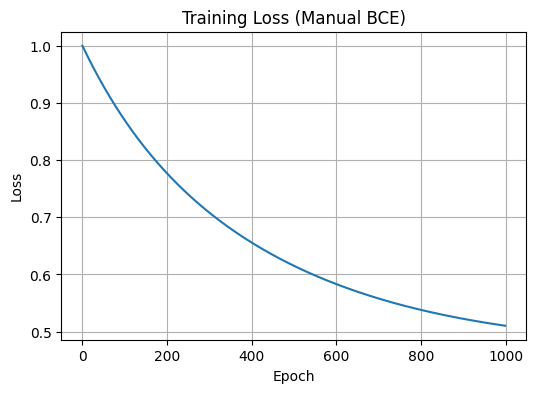

In [29]:
plt.figure(figsize=(6,4))
plt.plot(loss_history)
plt.title("Training Loss (Manual BCE)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


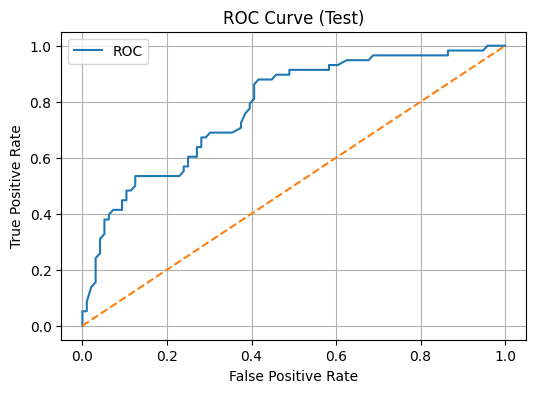

In [30]:
def roc_curve_manual(y_true_np, y_prob_np, num_thresh=200):
    thresholds = np.linspace(0, 1, num_thresh)
    tpr_list, fpr_list = [], []
    P = (y_true_np == 1).sum()
    N = (y_true_np == 0).sum()
    for t in thresholds:
        y_pred = (y_prob_np >= t).astype(np.float32)
        TP = ((y_true_np == 1) & (y_pred == 1)).sum()
        FP = ((y_true_np == 0) & (y_pred == 1)).sum()
        FN = ((y_true_np == 1) & (y_pred == 0)).sum()
        TN = ((y_true_np == 0) & (y_pred == 0)).sum()
        TPR = TP / (TP + FN + 1e-12)
        FPR = FP / (FP + TN + 1e-12)
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    return np.array(fpr_list), np.array(tpr_list)

y_test_np = y_test_t.numpy().reshape(-1)
probs_test_np = probs_te.numpy().reshape(-1)
fpr, tpr = roc_curve_manual(y_test_np, probs_test_np)

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1], [0,1], linestyle="--")
plt.title("ROC Curve (Test)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend()
plt.show()


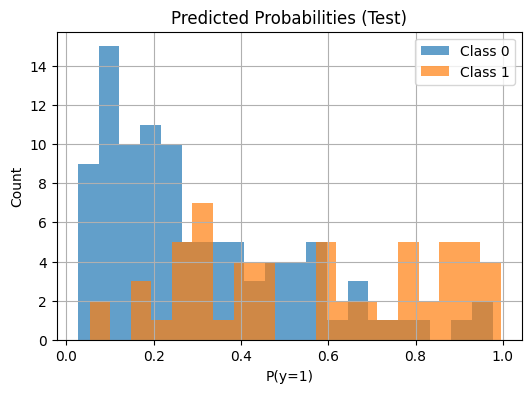

In [31]:
plt.figure(figsize=(6,4))
plt.hist(probs_test_np[y_test_np==0], bins=20, alpha=0.7, label="Class 0")
plt.hist(probs_test_np[y_test_np==1], bins=20, alpha=0.7, label="Class 1")
plt.title("Predicted Probabilities (Test)")
plt.xlabel("P(y=1)")
plt.ylabel("Count")
plt.legend()
plt.grid(True)
plt.show()